## Phase 1:
-   CTPN
-   SVN

### Load file path

In [2]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
# get link of ads and non ads images
from os import walk
f = []
ctpn_output_path = "../data/dataset/ctpn_output/testing_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_path):
    f.append(filenames)
    break
f = f[0]

In [4]:
ads_data = []
for name in f:
    ads_data.append([i[:-1] for i in open(ctpn_output_path + name,'r').readlines() if i !="\n"])

Get height and width of image

In [5]:
img_path = "../data/dataset/testing_data"
hw_ads = [PIL.Image.open(img_path + "/" + name[:-3] + "png").size for name in f] 

In [6]:
def extract_info(arr):
    arr = [int(i) for i in arr.split(",")[:-1]]
    h_b = arr[-1]-arr[1]
    w_b = arr[2] - arr[0]
    h_cb = (arr[-1]+arr[1])//2
    w_cb = (arr[2]+arr[0])//2
    return h_b,w_b,h_cb,w_cb

In [7]:
def sort_weight(bb, temp_scale,temp_distance=None):
    if temp_distance != None:
        temp_scale_sort = sorted(temp_scale)
        temp_distance_sort = sorted(temp_distance)
        bb_t = set()
        for distance in temp_distance_sort[-n_att:]:
            bb_t.add(bb[temp_distance_sort.index(distance)])
        for scale in temp_scale_sort[-n_att:]:
            bb_t.add(bb[temp_scale_sort.index(scale)])
        return list(bb_t),temp_scale_sort[-n_att:] + temp_distance_sort[-n_att:]
    else:
        w = sorted(temp_scale)
        bb_t = []
        for i in range(n_att):
            bb_t.append(bb[temp_scale.index(w[-n_att+i])])
        return bb_t,w[-n_att:]

$$x = max(H_b/W_b) +...+ max ((|H_cb-H_c+1)*(|W_cb-W_c+1)/(H_c*W_c))$$

In [8]:
n_att = 10
w_ads = []
for bbs,hw in zip(ads_data,hw_ads):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_ads.append(w_t)


In [9]:
X = w_ads 
y = [0]*len(w_ads)
for i in range(len(f)):
    if f[i][:3] == "ads":
        y[i] = 1

## Load SVM by joblid

In [10]:
import joblib
import sklearn.metrics as metrics

In [11]:
clf2 = joblib.load("../phase_1/svm_phase_1_v2.pkl")
clf2.probability = True
phase_1 = clf2.predict_proba(X)

In [12]:
y[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
phase_1[:10]

array([[0.933063  , 0.066937  ],
       [0.50871309, 0.49128691],
       [0.81066628, 0.18933372],
       [0.935897  , 0.064103  ],
       [0.89435872, 0.10564128],
       [0.97046407, 0.02953593],
       [0.91238628, 0.08761372],
       [0.97517162, 0.02482838],
       [0.44327505, 0.55672495],
       [0.47605008, 0.52394992]])

In [14]:
y_phase1 = [0] * len(y)
for i,r in enumerate(phase_1):
    if r[0] > r[1]:
        y_phase1[i] = 1

In [15]:
metrics.confusion_matrix(y,y_phase1)

array([[266,  27],
       [ 23, 350]], dtype=int64)

In [16]:
metrics.accuracy_score(y,y_phase1)

0.924924924924925

## Phase 2:
-   Xception

In [17]:
from tensorflow.keras.models import load_model
import os

In [18]:
from PIL import Image
import numpy as np
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [19]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image,(180,180,3))
    np_image = np.expand_dims(np_image, axis = 0)
    return np_image

In [20]:
model = load_model('../phase_2/xception/model/save_at_40.h5')

In [21]:
ads_path = "../data/dataset/testing_data/"

In [22]:
phase_2 = []
for name in f:
    r =model.predict(load(ads_path + name[:-3] + "png"))
    phase_2.append([1-r[0][0], r[0][0]])

In [23]:
phase_2[:10]

[[0.9996516704559326, 0.00034832954],
 [0.9999997151579407, 2.8484206e-07],
 [0.9999689133983338, 3.10866e-05],
 [0.9995241463184357, 0.00047585368],
 [0.9996791481971741, 0.0003208518],
 [0.9999999972622811, 2.737719e-09],
 [0.99847012758255, 0.0015298724],
 [0.9999999709479699, 2.905203e-08],
 [0.9999993381081822, 6.618918e-07],
 [0.9999999221356433, 7.786436e-08]]

In [24]:
y_phase2 = [0]*len(y)
for i,r in enumerate(phase_2):
    if r[0] > r[1]:
        y_phase2[i] = 1

In [25]:
metrics.confusion_matrix(y,y_phase2)

array([[245,  48],
       [  6, 367]], dtype=int64)

In [26]:
metrics.accuracy_score(y,y_phase2)

0.918918918918919

### Save results of phase_1 and phase_2

In [27]:
import pickle

In [28]:
with open("./phase_1.pkl", "wb") as f:
    pickle.dump([list(i) for i in phase_1],f)
with open("./phase_2.pkl", "wb") as f:
    pickle.dump(phase_2,f)

### Load phase_1 and phase_2

In [37]:
# with open("./phase_1.pkl", "rb") as f:
#     phase_1 = pickle.load(f)
# with open("./phase_2.pkl", "rb") as f:
#     phase_2 = pickle.load(f)

## Evaluating model

In [29]:

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
y_pred = [0]*len(y)
for i in range(len(y)):
    ads_r = (phase_1[i][0] + phase_2[i][0])/2
    non_ads_r = (phase_1[i][1] + phase_2[i][1])/2
    if ads_r > non_ads_r:
        y_pred[i] = 1

In [31]:
r = metrics.confusion_matrix(y, y_pred)
print("Confusion matrix: \n", r)

Confusion matrix: 
 [[273  20]
 [  6 367]]


In [32]:
acc = metrics.accuracy_score(y, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.960960960960961


<AxesSubplot:>

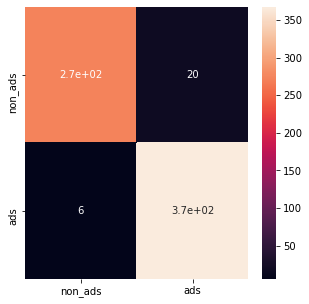

In [33]:
df_cm = pd.DataFrame(r, index = ['non_ads','ads'],
                  columns = ['non_ads','ads'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)